<img src="https://devra.ai/analyst/notebook/2797/image.jpg" style="width: 100%; height: auto;" />

In [3]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # For headless environments
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  

import seaborn as sns

# Ensure inline plotting in notebooks
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Set a seaborn theme for the plots
sns.set(style='whitegrid')

## Data Loading and Inspection

In [7]:
# Load the CSV file from the directory
csv_file_path = "C:/DATA SET/EV/electric_vehicles_dataset.csv"
try:
    df = pd.read_csv(csv_file_path)
    print('CSV file loaded successfully.')
except Exception as e:
    print(f'An error occurred while loading the CSV file: {e}')

# Display the first few rows of the dataset
df.head()

CSV file loaded successfully.


,Vehicle_ID,Manufacturer,Model,Year,Battery_Type,Battery_Capacity_kWh,Range_km,Charging_Type,Charge_Time_hr,Price_USD,Color,Country_of_Manufacture,Autonomous_Level,CO2_Emissions_g_per_km,Safety_Rating,Units_Sold_2024,Warranty_Years
0,1,Acura,ZDX (with GM Ultium),2015,Lithium-titanate,55.8,214,CHAdeMO,9.0,111203.94,Matte White,UK,0.0,NaN,5.0,19726,3
1,2,Lamborghini,Revuelto (PHEV),2025,Lithium-titanate,90.8,212,Vehicle-to-Home (V2H),7.3,127131.65,White,Netherlands,2.0,0.0,4.0,3349,3
2,3,NIO,ET7,2020,Calcium-ion,64.7,235,Level 2 Charging,8.9,94347.37,Beige,UK,5.0,0.0,5.0,6300,5
3,4,Audi,e-tron,2025,Lithium-iron phosphate,120.5,140,Ultra-Fast Charging (350 kW+),10.5,75615.15,Sunset Orange,Argentina,2.0,0.0,5.0,2339,5
4,5,Acura,ZDX (with GM Ultium),2023,Lithium-titanate,51.8,336,Plug-in Hydrogen Refueling,3.6,141046.94,Ice Silver,United Arab Emirates,2.0,0.0,3.0,1051,4


## Data Cleaning and Preprocessing

Before diving into the analysis, it is important to check for missing values and ensure the data types are correct. Notably, some columns like date or year might need formatting (although here we only have a 'Year' column which is numeric).

In [8]:
# Check info and data types
df.info()

# Check the shape of the dataset
print('Dataset shape:', df.shape)

# Let's look into missing values in each column
missing_values = df.isnull().sum()
print('Missing values in each column:')
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3022 entries, 0 to 3021
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Vehicle_ID              3022 non-null   int64  
 1   Manufacturer            3022 non-null   object 
 2   Model                   3022 non-null   object 
 3   Year                    3022 non-null   int64  
 4   Battery_Type            3022 non-null   object 
 5   Battery_Capacity_kWh    3022 non-null   float64
 6   Range_km                3022 non-null   int64  
 7   Charging_Type           3022 non-null   object 
 8   Charge_Time_hr          3022 non-null   float64
 9   Price_USD               3022 non-null   float64
 10  Color                   3022 non-null   object 
 11  Country_of_Manufacture  3022 non-null   object 
 12  Autonomous_Level        2580 non-null   float64
 13  CO2_Emissions_g_per_km  2430 non-null   float64
 14  Safety_Rating           2685 non-null   

In [9]:
# Fill or drop missing values as necessary
# For simplicity, we fill numeric missing values with the median and categorical with the mode
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f'Filled missing values in numeric column {col} with median: {median_value}')

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f'Filled missing values in categorical column {col} with mode: {mode_value}')

# Verify that there are no remaining missing values
print('Remaining missing values:')
print(df.isnull().sum())

Filled missing values in numeric column Autonomous_Level with median: 3.0
Filled missing values in numeric column CO2_Emissions_g_per_km with median: 0.0
Filled missing values in numeric column Safety_Rating with median: 4.0
Remaining missing values:
Vehicle_ID                0
Manufacturer              0
Model                     0
Year                      0
Battery_Type              0
Battery_Capacity_kWh      0
Range_km                  0
Charging_Type             0
Charge_Time_hr            0
Price_USD                 0
Color                     0
Country_of_Manufacture    0
Autonomous_Level          0
CO2_Emissions_g_per_km    0
Safety_Rating             0
Units_Sold_2024           0
Warranty_Years            0
dtype: int64


## Exploratory Data Analysis

,Vehicle_ID,Year,Battery_Capacity_kWh,Range_km,Charge_Time_hr,Price_USD,Autonomous_Level,CO2_Emissions_g_per_km,Safety_Rating,Units_Sold_2024,Warranty_Years
count,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.000000,3022.0,3022.000000,3022.000000,3022.000000
mean,1511.500000,2020.019523,84.314692,349.901059,6.212045,90611.906760,2.589676,0.0,3.995698,10207.072799,3.997353
std,872.520582,3.132083,37.210461,145.406139,3.350597,34654.533838,1.592476,0.0,0.772531,5771.619003,0.821746
min,1.000000,2015.000000,20.000000,100.000000,0.500000,30014.460000,0.000000,0.0,3.000000,6.000000,3.000000
25%,756.250000,2017.000000,52.425000,222.000000,3.300000,61257.390000,1.000000,0.0,3.000000,5145.500000,3.000000
50%,1511.500000,2020.000000,83.600000,347.000000,6.200000,90929.705000,3.000000,0.0,4.000000,10350.000000,4.000000
75%,2266.750000,2023.000000,115.800000,478.000000,9.100000,120199.842500,4.000000,0.0,5.000000,15128.000000,5.000000
max,3022.000000,2025.000000,150.000000,600.000000,12.000000,149978.530000,5.000000,0.0,5.000000,19996.000000,5.000000


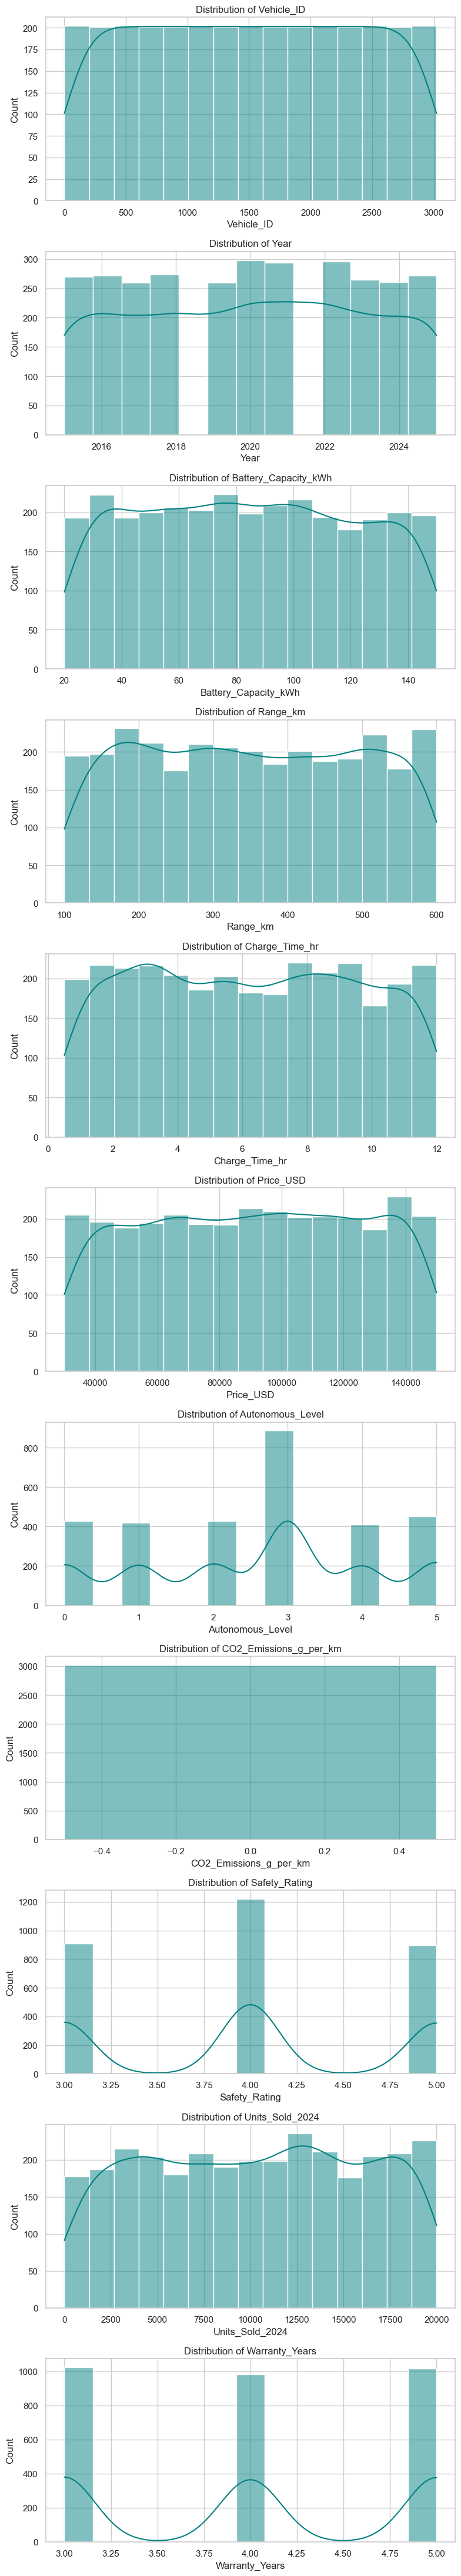

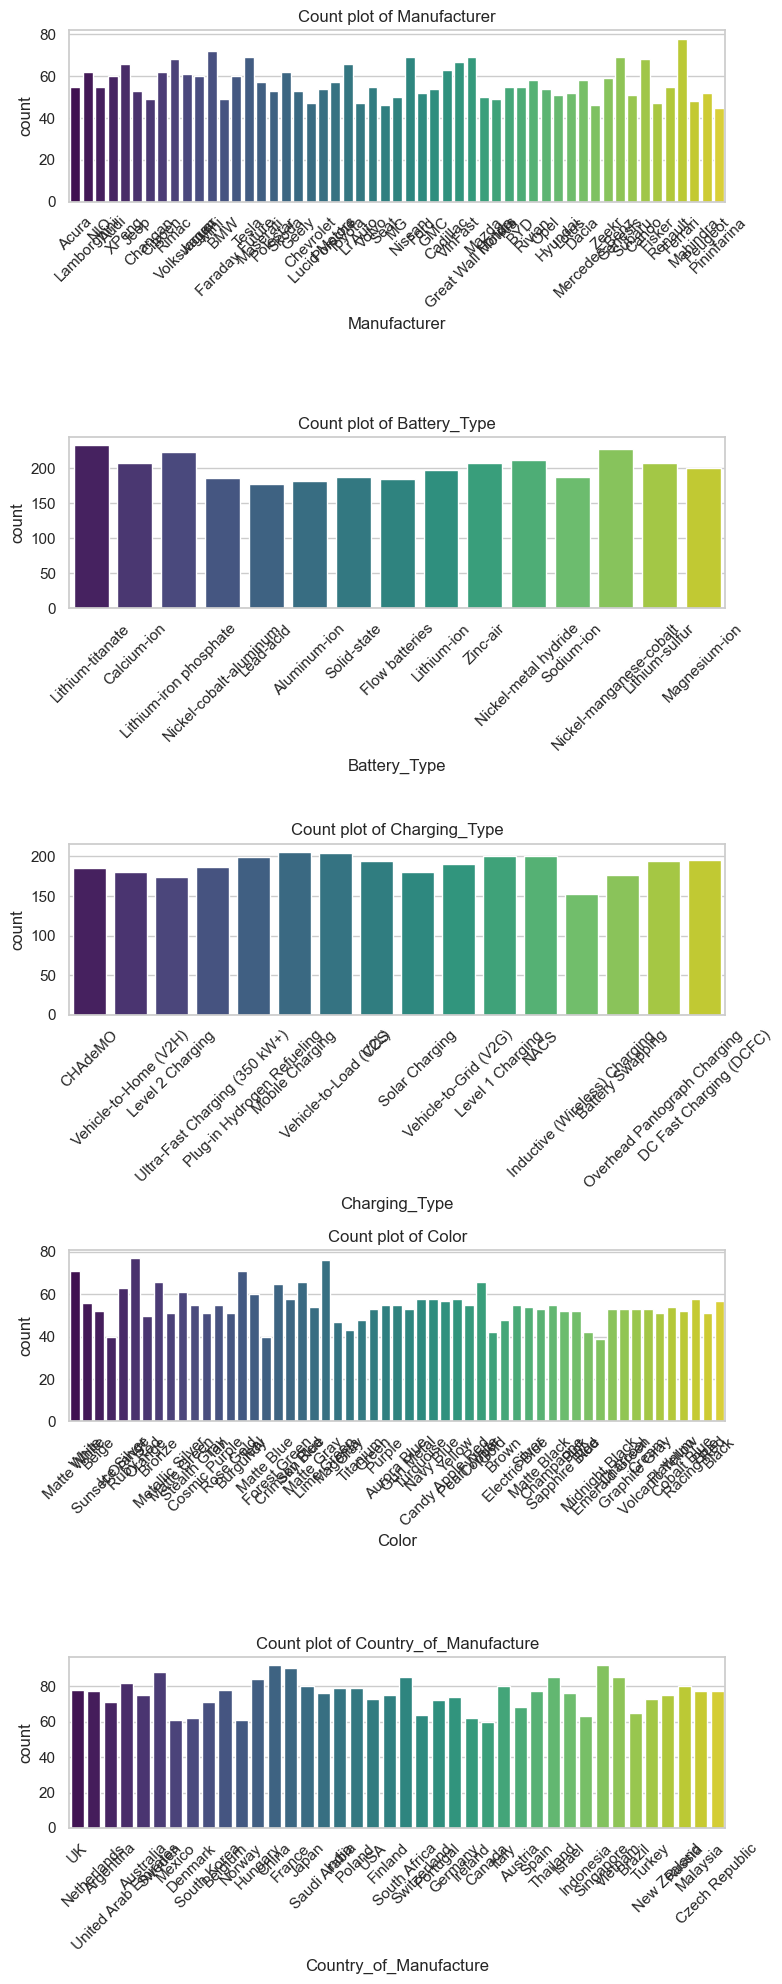

In [10]:
# A quick summary of the dataset statistics
display(df.describe())

# Plotting distributions for numeric features using histograms
numeric_df = df.select_dtypes(include=[np.number])
numeric_cols = numeric_df.columns

fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=1, figsize=(8, 4*len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color='teal')
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

# Count plots for some categorical features
categorical_features = ['Manufacturer', 'Battery_Type', 'Charging_Type', 'Color', 'Country_of_Manufacture']
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(8, 4*len(categorical_features)))
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Count plot of {col}")
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

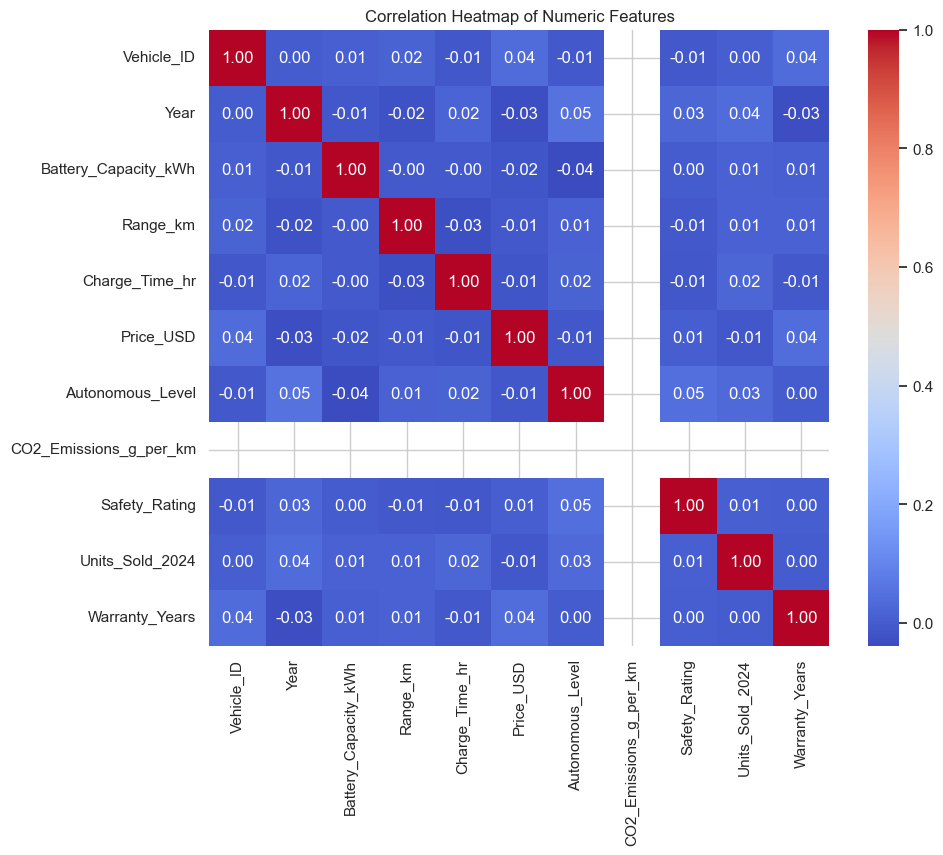

In [11]:
# If there are 4 or more numeric columns, display a correlation heatmap
if len(numeric_cols) >= 4:
    corr = numeric_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

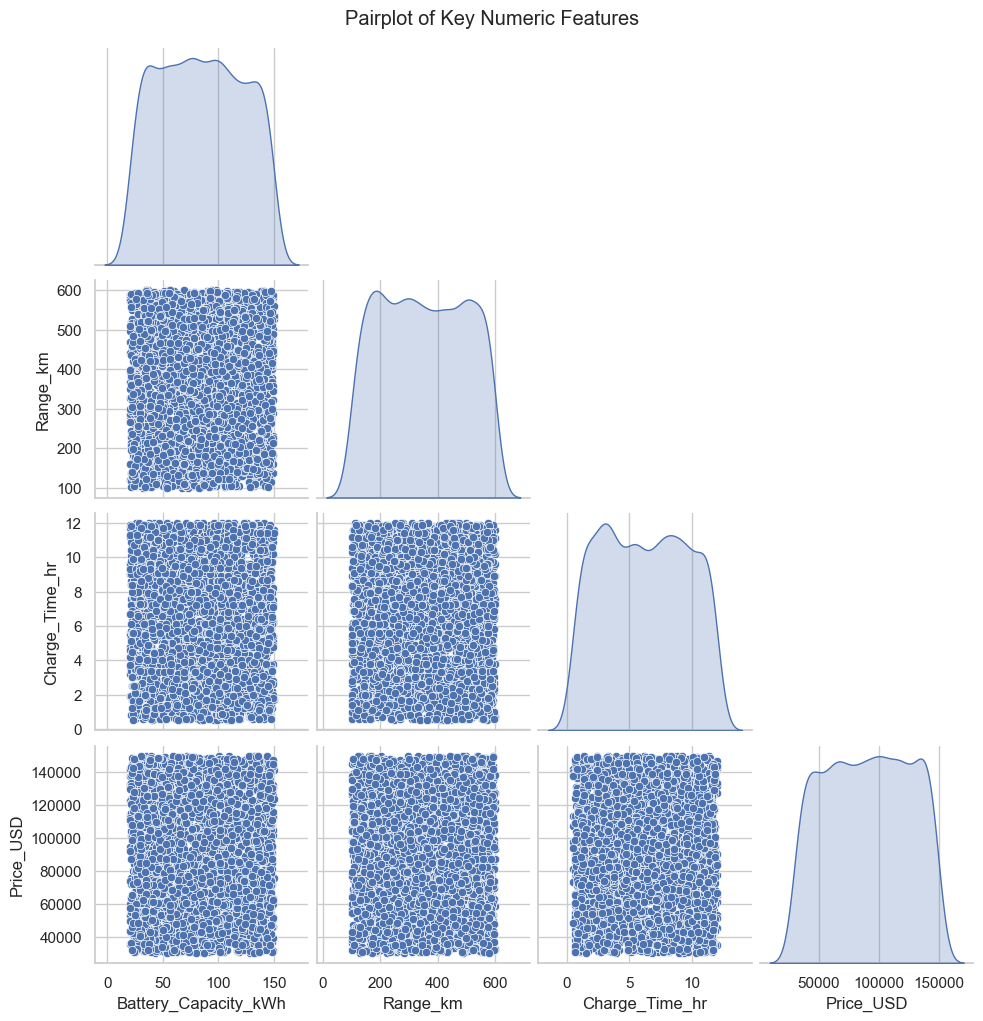

In [12]:
# Pairplot across a subset of features to see pairwise relationships
pairplot_features = ['Battery_Capacity_kWh', 'Range_km', 'Charge_Time_hr', 'Price_USD']
sns.pairplot(df[pairplot_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Key Numeric Features', y=1.02)
plt.show()

## Predictive Modeling

We will now attempt to predict the Price_USD of the electric vehicles using a simple linear regression model. A few numeric and categorical features will be used as predictors. 

In [13]:
# For the predictor, let's choose Price_USD as the target variable.
# We will use numeric features and encode a few categorical features.

# First, select predictor and target columns
target = 'Price_USD'

# We'll choose a subset of features that are likely to influence price
features = ['Year', 'Battery_Capacity_kWh', 'Range_km', 'Charge_Time_hr', 'Autonomous_Level', 'Safety_Rating', 'Units_Sold_2024', 'Warranty_Years']

# Additionally, incorporate a categorical variable such as Manufacturer using one-hot encoding
df_model = df[features + ['Manufacturer']].copy()
df_model = pd.get_dummies(df_model, columns=['Manufacturer'], drop_first=True)

# Define X and y
X = df_model.drop(target, axis=1, errors='ignore')
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model R-squared Score: {r2:.2f}")

Linear Regression Model R-squared Score: -0.05


*Conclusion

*We explored an electric vehicles dataset, cleaned and preprocessed the data, performed several visualizations, and built a simple linear regression model to predict the price.